# Separate notebook for pre processing data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read the training and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

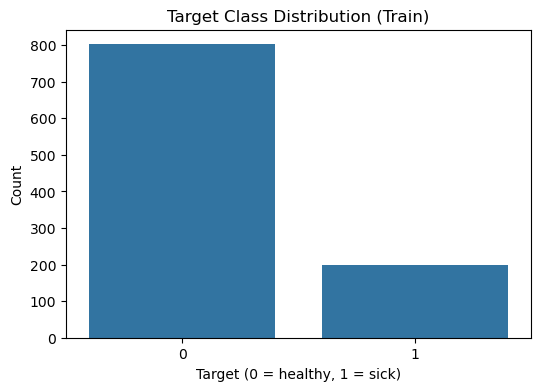

Class distribution in train:
target
0    802
1    198
Name: count, dtype: int64


In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='target')
plt.title("Target Class Distribution (Train)")
plt.xlabel("Target (0 = healthy, 1 = sick)")
plt.ylabel("Count")
plt.show()

print("Class distribution in train:")
print(train_df['target'].value_counts())

 ### Majority of entries are 0
 ignoring for now as "scale_pos_weight" in xgboost and "auto_class_weights" in catboost will be used

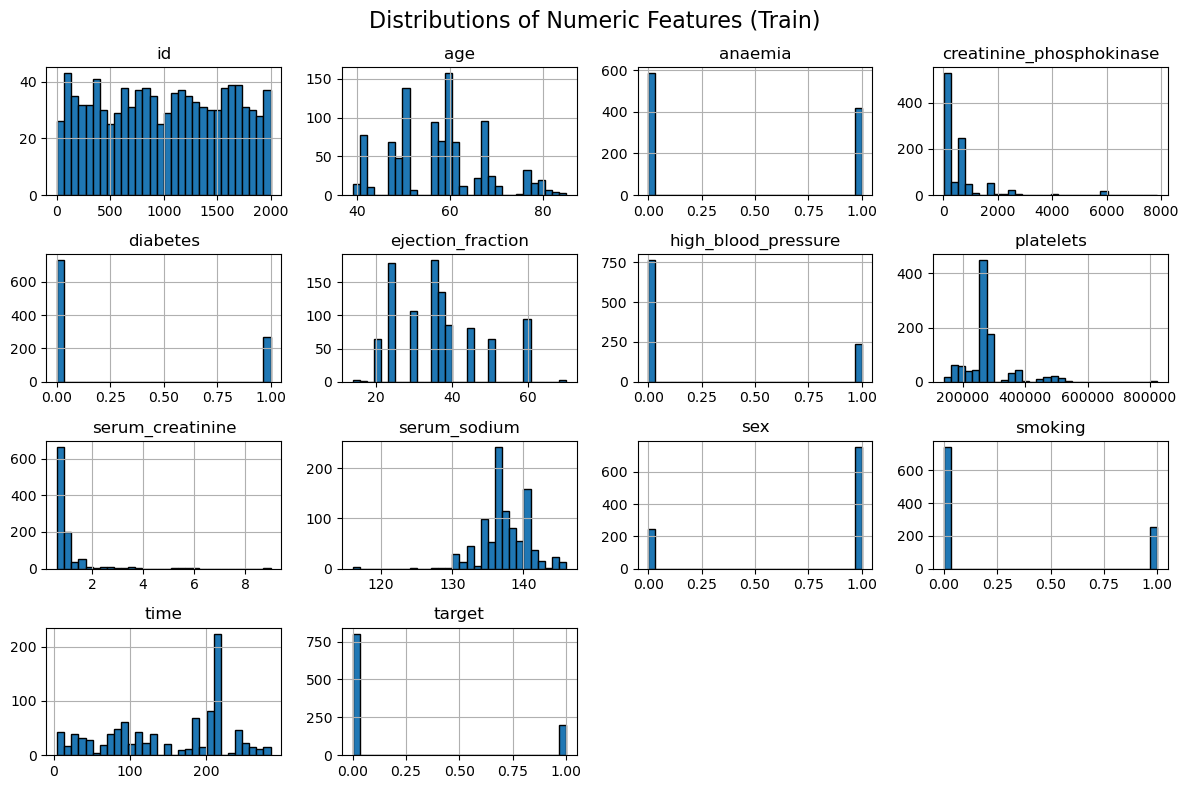

In [5]:
numeric_cols = list(train_df.select_dtypes(include=[np.number]).columns.values)

train_df[numeric_cols].hist(bins=30, figsize=(12, 8), edgecolor='black')
plt.suptitle("Distributions of Numeric Features (Train)", fontsize=16)
plt.tight_layout()
plt.show()

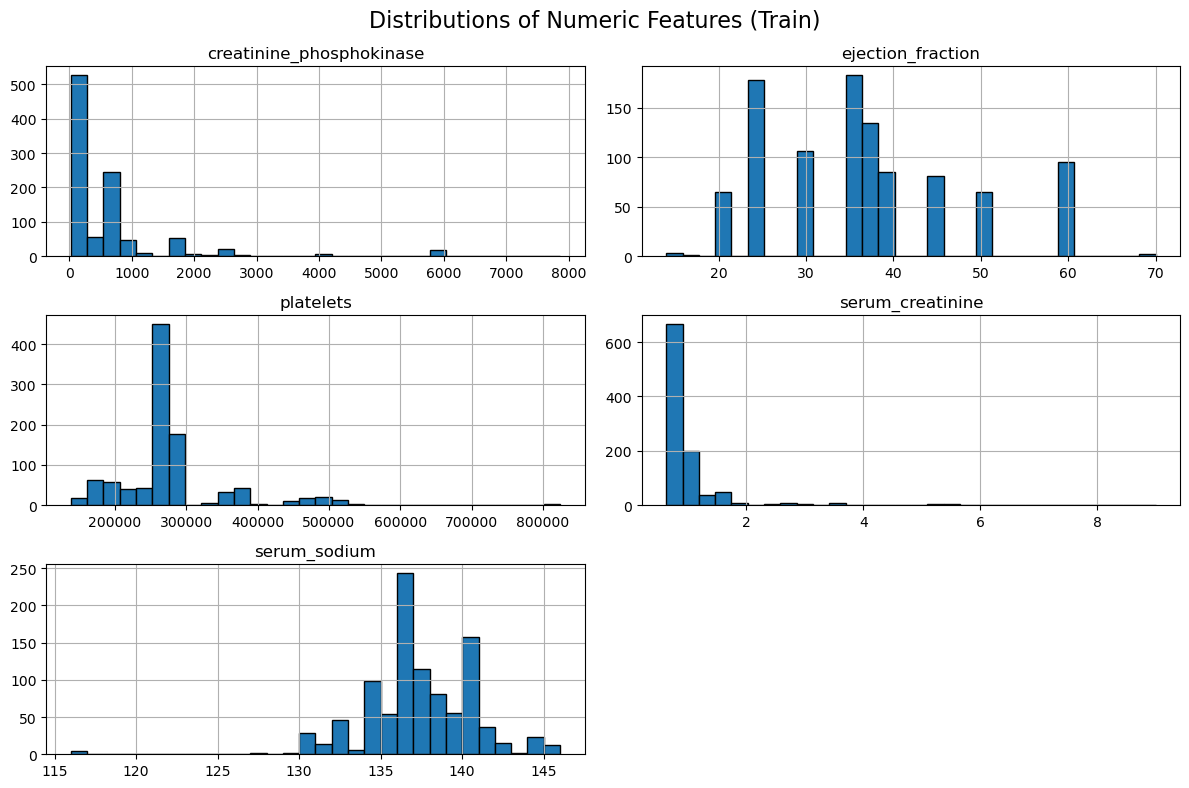

In [6]:
possible_outliners = ['creatinine_phosphokinase',
 'ejection_fraction',
 'platelets',
 'serum_creatinine',
 'serum_sodium']
train_df[possible_outliners].hist(bins=30, figsize=(12, 8), edgecolor='black')
plt.suptitle("Distributions of Numeric Features (Train)", fontsize=16)
plt.tight_layout()
plt.show()

In [57]:
def drop_iqr_outliers(
    df: pd.DataFrame,
    features: list,
    lower_quantile: float = 0.15,
    upper_quantile: float = 0.85,
    iqr_multiplier: float = 1.5
    ) -> pd.DataFrame:
    df_copy = df.copy()
    mask = pd.Series(True, index=df_copy.index)
    
    for col in features:
        # Calculate Q1, Q3 and IQR
        Q1 = df_copy[col].quantile(lower_quantile)
        Q3 = df_copy[col].quantile(upper_quantile)
        IQR = Q3 - Q1
        
        # Define outlier bounds
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        
        # Update mask to keep only values within bounds
        mask &= df_copy[col].between(lower_bound, upper_bound)
    
    cleaned_df = df_copy[mask].reset_index(drop=True)
    print(f"Original shape: {df.shape}, after outlier removal: {cleaned_df.shape}")
    return cleaned_df

In [60]:
train_no_outliers = drop_iqr_outliers(train_df,possible_outliners)

Original shape: (1000, 14), after outlier removal: (808, 14)


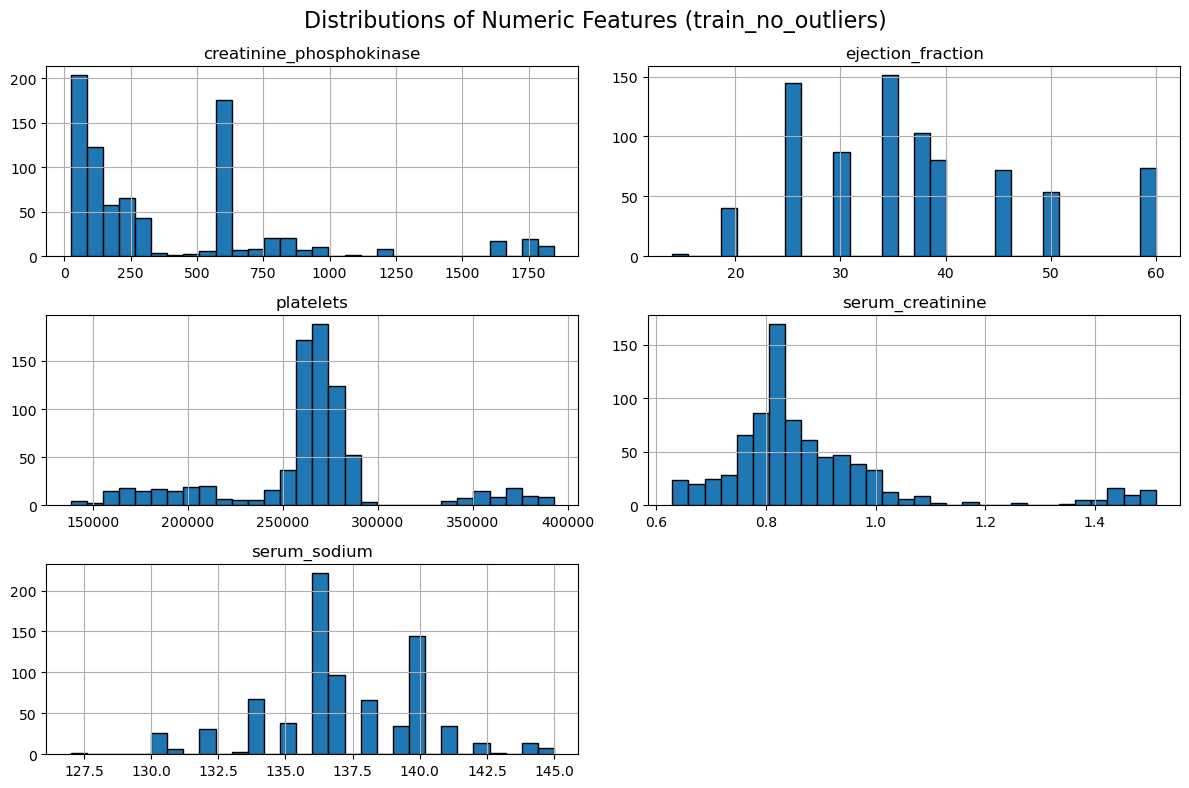

In [8]:
possible_outliners = ['creatinine_phosphokinase',
 'ejection_fraction',
 'platelets',
 'serum_creatinine',
 'serum_sodium']
train_no_outliers[possible_outliners].hist(bins=30, figsize=(12, 8), edgecolor='black')
plt.suptitle("Distributions of Numeric Features (train_no_outliers)", fontsize=16)
plt.tight_layout()
plt.show()

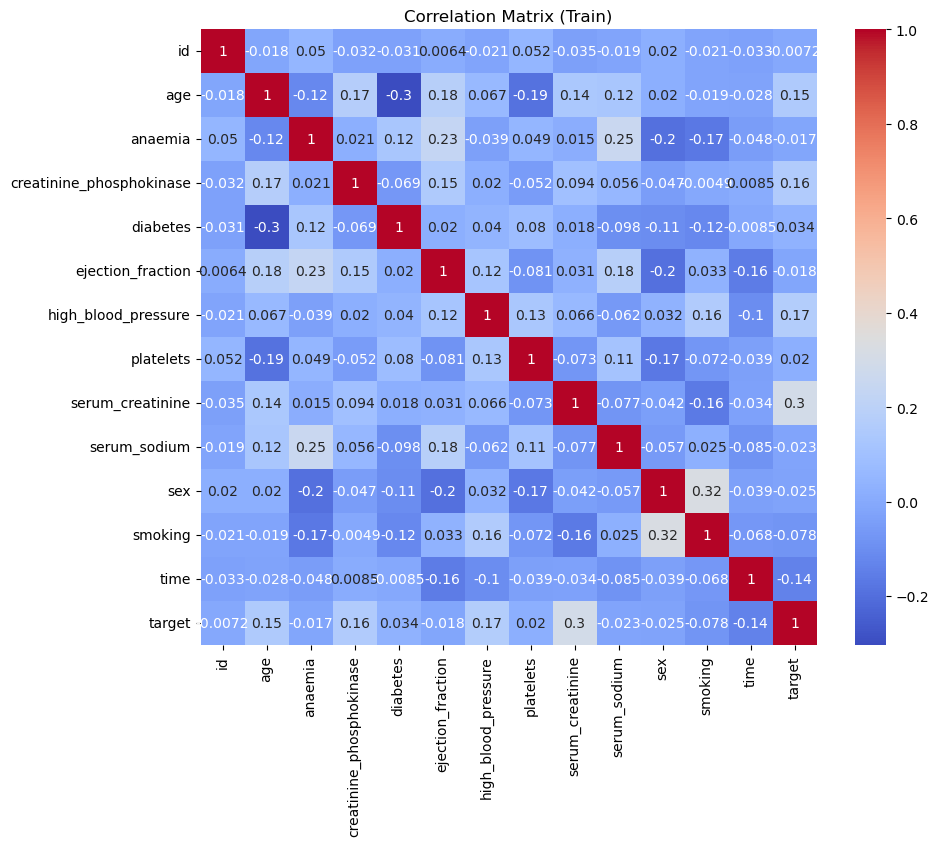

In [9]:
plt.figure(figsize=(10, 8))
corr_matrix = train_no_outliers[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix (Train)")
plt.show()

# Choosing features

In [10]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [19]:
# 1. Prepare X and y
X = train_no_outliers.drop(columns=['id', 'target'])
y = train_no_outliers['target']

# 2. Choose a base estimator
estimator = LogisticRegression(solver='liblinear')

# 3. Set up RFE: here we ask it to pick the top 5 features
selector = RFE(estimator=estimator, 
               n_features_to_select=5, 
               step=1,                # remove one feature at each iteration
               verbose=1)

# 4. Fit RFE
selector.fit(X, y)

# 5. Which features were selected?
selected_mask = selector.support_
selected_features = X.columns[selected_mask]
print("Selected features:", list(selected_features))

# 6. Full ranking of all features (1 = best, larger = eliminated earlier)
ranking = selector.ranking_
print("Feature rankings:")
for feat, rank in zip(X.columns, ranking):
    print(f"  {feat}: {rank}")
rfe_selected_features = selected_features

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Selected features: ['high_blood_pressure', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking']
Feature rankings:
  age: 3
  anaemia: 5
  creatinine_phosphokinase: 7
  diabetes: 2
  ejection_fraction: 4
  high_blood_pressure: 1
  platelets: 8
  serum_creatinine: 1
  serum_sodium: 1
  sex: 1
  smoking: 1
  time: 6


In [12]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# same X, y as above
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfecv = RFECV(estimator=estimator,
              step=1,
              cv=cv,
              scoring='roc_auc',            # or 'accuracy', etc.
              min_features_to_select=1,
              verbose=1)

rfecv.fit(X, y)

print("Optimal number of features:", rfecv.n_features_)
print("Support mask:", rfecv.support_)
print("Selected features:", list(X.columns[rfecv.support_]))


Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting est

In [13]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(estimator,
                                n_features_to_select=5,
                                direction='backward',    # remove features one by one
                                cv=5,
                                scoring='roc_auc')

sfs.fit(X, y)
print("Selected features:", list(X.columns[sfs.get_support()]))


Selected features: ['creatinine_phosphokinase', 'high_blood_pressure', 'serum_creatinine', 'serum_sodium', 'time']


In [14]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

In [15]:
# 1. Prepare  data
X = train_no_outliers.drop(columns=['id', 'target'])
y = train_no_outliers['target']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
# 2A. XGBoost 
xgb = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)
xgb.fit(X_train, y_train)

# 3A. Select features whose importance is above the median
sfm_xgb = SelectFromModel(xgb, threshold='median', prefit=True)
X_train_sel_xgb = sfm_xgb.transform(X_train)
selected_feats_xgb = X_train.columns[sfm_xgb.get_support()]
print("XGBoost selected:", list(selected_feats_xgb))


# 2B. CatBoost example
cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    auto_class_weights='Balanced',
    eval_metric='AUC',
    random_seed=42,
    verbose=False
)
cb.fit(X_train, y_train)

# 3B. Use CatBoost’s built‑in feature_importances_
importances_cb = cb.get_feature_importance(type='FeatureImportance')
sfm_cb = SelectFromModel(cb, threshold='median', prefit=True)
X_train_sel_cb = sfm_cb.transform(X_train)
selected_feats_cb = X_train.columns[sfm_cb.get_support()]
print("CatBoost selected:", list(selected_feats_cb))


/Users/user/anaconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:56:56] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/user/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


XGBoost selected: ['creatinine_phosphokinase', 'platelets', 'serum_creatinine', 'serum_sodium', 'smoking', 'time']
CatBoost selected: ['age', 'creatinine_phosphokinase', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']


/Users/user/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [44]:
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import pandas as pd

# 1. Fit your model (here XGBoost as an example)
X = train_no_outliers.drop(columns=['id','target'])
y = train_no_outliers['target']
model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(y==0).sum()/(y==1).sum(),
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)
model.fit(X, y)

# 2. Compute permutation importances on hold‑out or cross‑val data
#    Here we just reuse X, y for simplicity
r = permutation_importance(
    estimator=model,
    X=X,
    y=y,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc'
)

# 3. Turn them into a Series and pick a threshold
perm_imp = pd.Series(r.importances_mean, index=X.columns)
threshold = perm_imp.median()   # you can choose any cutoff

# 4. Select features above that threshold
perm_selected_features = perm_imp[perm_imp > threshold].index.tolist()
print("Features selected by permutation importance:", perm_selected_features)

/Users/user/anaconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [04:08:08] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Features selected by permutation importance: ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'time']


In [45]:
xgb_selected_features = selected_feats_xgb
cb_selected_features = selected_feats_cb
set_rfe    = set(rfe_selected_features)
set_xgb    = set(xgb_selected_features)
set_cb     = set(cb_selected_features)
set_perm   = set(perm_selected_features)


In [46]:
from collections import Counter
all_feats = list(set_rfe) + list(set_xgb) + list(set_cb) + list(set_perm)
freq = Counter(all_feats)
# Features selected by at least 3 of 4 methods:
stable = [f for f,c in freq.items() if c >= 3]
print("Stable features:", stable)

Stable features: ['serum_creatinine', 'serum_sodium', 'creatinine_phosphokinase', 'time', 'platelets']


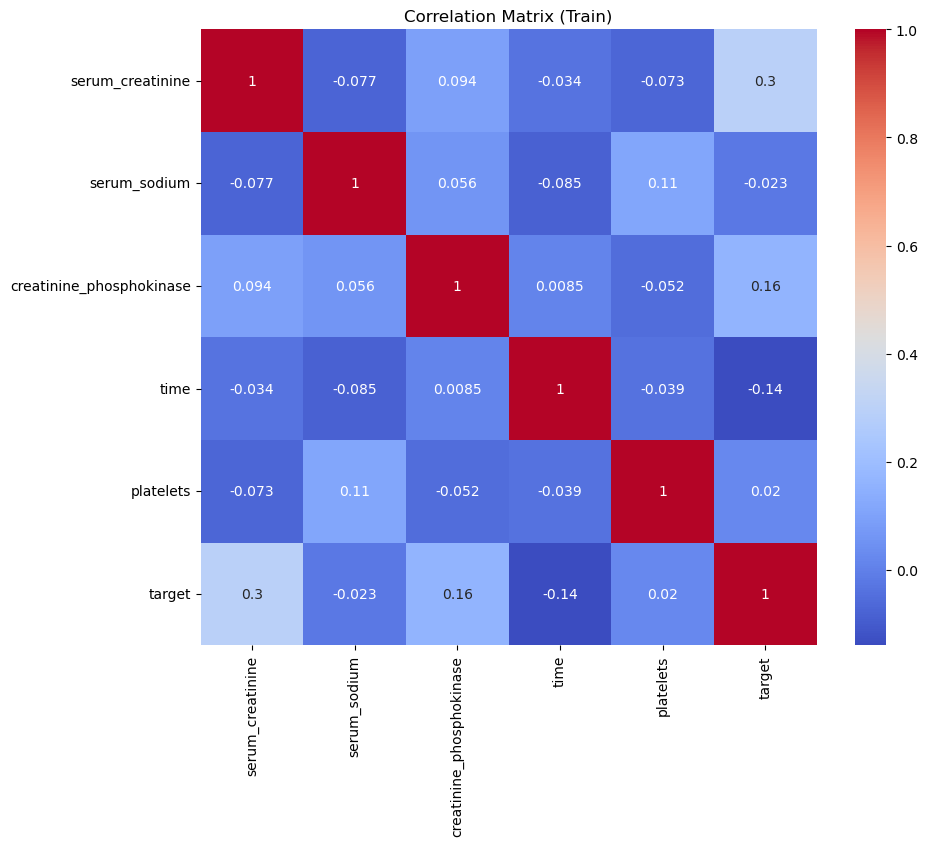

In [47]:
plt.figure(figsize=(10, 8))
corr_matrix = train_no_outliers[stable+['target']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix (Train)")
plt.show()

In [43]:
from collections import Counter
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier


In [55]:
# 1) Prepare X and y
X = train_no_outliers.drop(columns=['id', 'target'])
y = train_no_outliers['target']

# 2) Compute class counts and scale_pos_weight
counts = Counter(y)
neg = counts[0]
pos = counts[1]
scale_pos_weight = neg / pos

print(f"Negative samples: {neg}, Positive samples: {pos}")
print(f"Using scale_pos_weight = {scale_pos_weight:.2f}")

# 3) Define your feature‐sets (make sure these were computed already)
#    e.g. set_rfe, set_xgb, set_cb, stable (majority‐vote list)
subsets = {
    'intersection': list(set_rfe & set_xgb & set_cb& set_perm),
    'union':        list(set_rfe | set_xgb | set_cb| set_perm),
    'majority':     stable
}

# 4) Cross‐validate each subset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, feats in subsets.items():
    clf = XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='auc',
        random_state=42
    )
    scores = cross_val_score(
        clf,
        X[feats],
        y,
        cv=cv,
        scoring='roc_auc'
    )
    print(f"{name:12s} → mean ROC‑AUC: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


Negative samples: 667, Positive samples: 141
Using scale_pos_weight = 4.73
intersection → mean ROC‑AUC: 0.6339 ± 0.0470
union        → mean ROC‑AUC: 0.8656 ± 0.0144
majority     → mean ROC‑AUC: 0.8228 ± 0.0294


# Comparing models

### data reading

In [93]:
union_features = list(set_rfe | set_xgb | set_cb| set_perm)

In [94]:
X = train_no_outliers.drop(columns=['id', 'target'])
X = X[union_features]
y = train_no_outliers['target']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [97]:
from collections import Counter
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

In [98]:


# -------------------------------------------------------------------
# ASSUME X_train, X_val, y_train, y_val ARE ALREADY DEFINED
# -------------------------------------------------------------------

# 1) Compute class imbalance ratio for XGBoost
counts = Counter(y_train)
neg, pos = counts[0], counts[1]
scale_pos_weight = neg / pos
print(f"Training set: {neg} negatives, {pos} positives → scale_pos_weight={scale_pos_weight:.2f}\n")

# 2) Instantiate a suite of models
models = {
    "CatBoost": CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        auto_class_weights='Balanced',
        eval_metric='AUC',
        random_seed=42,
        early_stopping_rounds=50,
        verbose=False
    ),
    "XGBoost": XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='auc',
        scale_pos_weight=scale_pos_weight,
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )
}

# 3) Train & evaluate each model
results = []

for name, model in models.items():
    print(f"--- {name} ---")
    
    # Fit the model
    if name == "CatBoost":
        model.fit(X_train, y_train, eval_set=(X_val, y_val))
    else:
        model.fit(X_train, y_train)
    
    # Predict labels and probabilities
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Compute metrics
    auc   = roc_auc_score(y_val, y_pred_proba)
    acc   = accuracy_score(y_val, y_pred)
    
    print(f"ROC‑AUC:       {auc:.4f}")
    print(f"Accuracy:     {acc:.4f}")
    print("Classification report:")
    print(classification_report(y_val, y_pred, digits=4))
    print("\n")
    
    results.append((name, auc, acc))

# 4) Summarize results in a DataFrame
summary = pd.DataFrame(results, columns=["Model", "ROC‑AUC", "Accuracy"])
print("Summary of all models:\n", summary)


Training set: 533 negatives, 113 positives → scale_pos_weight=4.72

--- CatBoost ---
ROC‑AUC:       0.8926
Accuracy:     0.8765
Classification report:
              precision    recall  f1-score   support

           0     0.9130    0.9403    0.9265       134
           1     0.6667    0.5714    0.6154        28

    accuracy                         0.8765       162
   macro avg     0.7899    0.7559    0.7709       162
weighted avg     0.8705    0.8765    0.8727       162



--- XGBoost ---
ROC‑AUC:       0.8835
Accuracy:     0.8519
Classification report:
              precision    recall  f1-score   support

           0     0.9104    0.9104    0.9104       134
           1     0.5714    0.5714    0.5714        28

    accuracy                         0.8519       162
   macro avg     0.7409    0.7409    0.7409       162
weighted avg     0.8519    0.8519    0.8519       162



--- RandomForest ---
ROC‑AUC:       0.8982
Accuracy:     0.8642
Classification report:
              precisio

In [104]:
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, f1_score

# for CatBoost as example
probs = models['CatBoost'].predict_proba(X_val)[:,1]
prec, rec, th = precision_recall_curve(y_val, probs)

# find threshold maximizing F1₁
f1_scores = 2 * (prec * rec) / (prec + rec)
best = f1_scores.argmax()
best_thresh = th[best]
print("Best F1₁ thresh:", best_thresh, "→ F1₁ =", f1_scores[best])

# apply it
y_pred = (probs >= best_thresh).astype(int)
print("New recall₁:", recall_score(y_val, y_pred))
print("New precision₁:", precision_score(y_val, y_pred))


Best F1₁ thresh: 0.3807575355003758 → F1₁ = 0.6461538461538462
New recall₁: 0.75
New precision₁: 0.5675675675675675


221

In [112]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report

# ----------------------------------------------
# ASSUME X_train, X_val, y_train, y_val ARE DEFINED
# ----------------------------------------------

# 1) Base CatBoost estimator (silent, balanced classes)
base_cb = CatBoostClassifier(
    auto_class_weights='Balanced',
    eval_metric='AUC',
    random_seed=42,
    verbose=False
)

# 2) Cross‑validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ----------------------------------------------
# 3) COARSE GRID SEARCH
# ----------------------------------------------
coarse_param_grid = {
    'depth':           [4, 6, 8],
    'learning_rate':   [0.01, 0.05, 0.1],
    'l2_leaf_reg':     [1, 3, 5, 7],
    'iterations':      [200, 500, 1000],
    'border_count':    [32, 64, 128]
}

coarse_search = GridSearchCV(
    estimator=base_cb,
    param_grid=coarse_param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)
coarse_search.fit(X_train, y_train)

print("Coarse best params:", coarse_search.best_params_)
print("Coarse best AUC:   ", coarse_search.best_score_)

# ----------------------------------------------
# 4) FINE GRID SEARCH AROUND COARSE OPTIMUM
# ----------------------------------------------
best = coarse_search.best_params_
fine_param_grid = {
    'depth': [
        max(1, best['depth'] - 2),
        best['depth'],
        best['depth'] + 2
    ],
    'learning_rate': [
        best['learning_rate'] * 0.5,
        best['learning_rate'],
        best['learning_rate'] * 1.5
    ],
    'l2_leaf_reg': [
        max(1, best['l2_leaf_reg'] - 2),
        best['l2_leaf_reg'],
        best['l2_leaf_reg'] + 2
    ],
    'iterations': [
        max(100, best['iterations'] - 200),
        best['iterations'],
        best['iterations'] + 200
    ],
    'border_count': [
        max(1, best['border_count'] // 2),
        best['border_count'],
        min(255, best['border_count'] * 2)
    ]
}

fine_search = GridSearchCV(
    estimator=base_cb,
    param_grid=fine_param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)
fine_search.fit(X_train, y_train)

print("Fine best params:", fine_search.best_params_)
print("Fine best AUC:   ", fine_search.best_score_)

# ----------------------------------------------
# 5) TRAIN FINAL CATBOOST WITH OPTIMAL PARAMS
# ----------------------------------------------
final_cb = CatBoostClassifier(
    **fine_search.best_params_,
    auto_class_weights='Balanced',
    eval_metric='AUC',
    random_seed=42,
    verbose=False
)
final_cb.fit(X_train, y_train)

# 6) EVALUATE ON VALIDATION SET
proba = final_cb.predict_proba(X_val)[:, 1]
print("Final Cat


256

# Grid search catboost

In [129]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report

# ----------------------------------------------
# ASSUME X_train, X_val, y_train, y_val ARE DEFINED
# ----------------------------------------------

# 1) Base CatBoost estimator (silent, balanced classes)
base_cb = CatBoostClassifier(
    auto_class_weights='Balanced',
    eval_metric='AUC',
    random_seed=42,
    verbose=False
)

# 2) Cross‑validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ----------------------------------------------
# 3) COARSE GRID SEARCH
# ----------------------------------------------
coarse_param_grid = {
    'depth':           [4, 6, 8],
    'learning_rate':   [0.01, 0.05, 0.1],
    'l2_leaf_reg':     [1, 3, 5, 7],
    'iterations':      [200, 500, 1000],
    'border_count':    [32, 64, 128]
}

coarse_search = GridSearchCV(
    estimator=base_cb,
    param_grid=coarse_param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)
coarse_search.fit(X_train, y_train)

print("Coarse best params:", coarse_search.best_params_)
print("Coarse best AUC:   ", coarse_search.best_score_)

# ----------------------------------------------
# 4) FINE GRID SEARCH AROUND COARSE OPTIMUM
# ----------------------------------------------
best = coarse_search.best_params_
fine_param_grid = {
    'depth': [
        max(1, best['depth'] - 2),
        best['depth'],
        best['depth'] + 2
    ],
    'learning_rate': [
        best['learning_rate'] * 0.5,
        best['learning_rate'],
        best['learning_rate'] * 1.5
    ],
    'l2_leaf_reg': [
        max(1, best['l2_leaf_reg'] - 2),
        best['l2_leaf_reg'],
        best['l2_leaf_reg'] + 2
    ],
    'iterations': [
        max(100, best['iterations'] - 200),
        best['iterations'],
        best['iterations'] + 200
    ],
    'border_count': [
        max(1, best['border_count'] // 2),
        best['border_count'],
        min(255, best['border_count'] * 2)
    ]
}

fine_search = GridSearchCV(
    estimator=base_cb,
    param_grid=fine_param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)
fine_search.fit(X_train, y_train)

print("Fine best params:", fine_search.best_params_)
print("Fine best AUC:   ", fine_search.best_score_)

# ----------------------------------------------
# 5) TRAIN FINAL CATBOOST WITH OPTIMAL PARAMS
# ----------------------------------------------
final_cb = CatBoostClassifier(
    **fine_search.best_params_,
    auto_class_weights='Balanced',
    eval_metric='AUC',
    random_seed=42,
    verbose=False
)
final_cb.fit(X_train, y_train)

# 6) EVALUATE ON VALIDATION SET
proba = final_cb.predict_proba(X_val)[:, 1]
print("Final CatBoost ROC‑AUC:", roc_auc_score(y_val, proba))
print(classification_report(y_val, (proba >= 0.5).astype(int)))


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Coarse best params: {'border_count': 32, 'depth': 6, 'iterations': 200, 'l2_leaf_reg': 7, 'learning_rate': 0.1}
Coarse best AUC:    0.8660916820408666
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END border_count=32, depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.2s
[CV] END border_count=32, depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=   0.1s
[CV] END border_count=32, depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   0.1s
[CV] END border_count=32, depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   0.2s
[CV] END border_count=32, depth=4, iterations=200, l2_leaf_reg=5, learning_rate=0.01; total time=   0.1s
[CV] END border_count=32, depth=4, iterations=200, l2_leaf_reg=5, learning_rate=0.1; total time=   0.1s
[CV] END border_count=32, depth=4, iterations=200, l2_leaf_reg=7, learning_rate=0.01; total ti

ine best params: {'border_count': 32, 'depth': 6, 'iterations': 200, 'l2_leaf_reg': 7, 'learning_rate': 0.1}
Fine best AUC:    0.8660916820408666
Final CatBoost ROC‑AUC: 0.9019189765458422
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       134
           1       0.65      0.61      0.63        28

    accuracy                           0.88       162
   macro avg       0.79      0.77      0.78       162
weighted avg       0.87      0.88      0.87       162

In [139]:
from sklearn.metrics import precision_recall_curve, f1_score, recall_score, precision_score
import numpy as np

probs = final_cb.predict_proba(X_val)[:,1]
prec, rec, th = precision_recall_curve(y_val, probs)
f1s = 2*prec*rec/(prec+rec+1e-16)
best = np.nanargmax(f1s)
opt_thresh = th[best]

print("Optimum threshold:", opt_thresh)
print("Val recall₁:", rec[best])
print("Val precision₁:", prec[best])
print("Val F1₁:", f1s[best])


Optimum threshold: 0.610465990841679
Val recall₁: 0.6071428571428571
Val precision₁: 0.7391304347826086
Val F1₁: 0.6666666666666666


In [140]:
from sklearn.calibration import CalibratedClassifierCV

calibrator = CalibratedClassifierCV(final_cb, method='isotonic', cv='prefit')
calibrator.fit(X_val, y_val)
probs_cal = calibrator.predict_proba(X_val)[:,1]
# now redo threshold tuning on probs_cal instead of raw

In [142]:
probs = probs_cal
prec, rec, th = precision_recall_curve(y_val, probs)
f1s = 2*prec*rec/(prec+rec+1e-16)
best = np.nanargmax(f1s)
opt_thresh = th[best]

print("Optimum threshold:", opt_thresh)
print("Val recall₁:", rec[best])
print("Val precision₁:", prec[best])
print("Val F1₁:", f1s[best])

Optimum threshold: 0.3333333333333333
Val recall₁: 0.6071428571428571
Val precision₁: 0.7391304347826086
Val F1₁: 0.6666666666666666


### xgboost

In [61]:
# 3) Compute scale_pos_weight for imbalance
counts = Counter(y_train)
scale_pos_weight = counts[0] / counts[1]

# 4) Instantiate XGBoost with your chosen hyperparameters
model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

# 5) Fit on the entire training set
model.fit(X_train, y_train)

# Grid Search for Random Forest

In [146]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report

# ----------------------------------------------
# ASSUME X_train, X_val, y_train, y_val ARE DEFINED
# ----------------------------------------------

# 1) Base RandomForest estimator with class weighting for imbalance
base_rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 2) Cross‑validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ----------------------------------------------
# 3) COARSE GRID SEARCH
# ----------------------------------------------
coarse_param_grid = {
    'n_estimators':      [200, 500, 800, 1200],
    'max_depth':         [5, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf':  [1, 2, 4, 8],
    'max_features':      ['sqrt', 'log2']
}

coarse_search = GridSearchCV(
    estimator=base_rf,
    param_grid=coarse_param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)
coarse_search.fit(X_train, y_train)

print("Coarse best params:", coarse_search.best_params_)
print("Coarse best AUC:   ", coarse_search.best_score_)

# ----------------------------------------------
# 4) FINE GRID SEARCH AROUND COARSE OPTIMUM
# ----------------------------------------------
best = coarse_search.best_params_

# Build fine grid by taking small steps around the coarse best
fine_param_grid = {
    'n_estimators': [
        max(50, best['n_estimators'] - 200),
        best['n_estimators'],
        best['n_estimators'] + 200
    ],
    'max_depth': [
        max(1, best['max_depth'] - 5),
        best['max_depth'],
        best['max_depth'] + 5
    ],
    'min_samples_split': [
        max(2, best['min_samples_split'] - 2),
        best['min_samples_split'],
        best['min_samples_split'] + 2
    ],
    'min_samples_leaf': [
        max(1, best['min_samples_leaf'] - 1),
        best['min_samples_leaf'],
        best['min_samples_leaf'] + 1
    ],
    'max_features': [
        best['max_features']  # categorical: keep the same
    ]
}

fine_search = GridSearchCV(
    estimator=base_rf,
    param_grid=fine_param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)
fine_search.fit(X_train, y_train)

print("Fine best params:", fine_search.best_params_)
print("Fine best AUC:   ", fine_search.best_score_)

# ----------------------------------------------
# 5) TRAIN FINAL RANDOM FOREST WITH OPTIMAL PARAMS
# ----------------------------------------------
final_rf = RandomForestClassifier(
    **fine_search.best_params_,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
final_rf.fit(X_train, y_train)

# 6) EVALUATE ON VALIDATION SET
proba = final_rf.predict_proba(X_val)[:, 1]
print("Final RF ROC‑AUC:", roc_auc_score(y_val, proba))
print(classification_report(y_val, (proba >= 0.5).astype(int)))


Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Coarse best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Coarse best AUC:    0.864065214951877
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fine best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 700}
Fine best AUC:    0.8645008269658472
Final RF ROC‑AUC: 0.888592750533049
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       134
           1       0.57      0.57      0.57        28

    accuracy                           0.85       162
   macro avg       0.74      0.74      0.74       162
weighted avg       0.85      0.85      0.85       162



Coarse best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Coarse best AUC:    0.864065214951877
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fine best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 700}
Fine best AUC:    0.8645008269658472
Final RF ROC‑AUC: 0.888592750533049
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       134
           1       0.57      0.57      0.57        28

    accuracy                           0.85       162
   macro avg       0.74      0.74      0.74       162
weighted avg       0.85      0.85      0.85       162

In [147]:
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, f1_score
import numpy as np

probs_rf = final_rf.predict_proba(X_val)[:, 1]
prec, rec, th = precision_recall_curve(y_val, probs_rf)
f1s = 2 * prec * rec / (prec + rec + 1e-16)
best = np.nanargmax(f1s)
opt_thresh_rf = th[best]

print("Optimal RF threshold:", opt_thresh_rf)
print("Recall₁:", rec[best], "Precision₁:", prec[best], "F1₁:", f1s[best])


Optimal RF threshold: 0.4212903773452662
Recall₁: 0.8214285714285714 Precision₁: 0.5476190476190477 F1₁: 0.6571428571428571


In [199]:
probs_test_rf = final_rf.predict_proba(X_test)[:,1]
y_test_rf = (probs_test_rf >= 0.49).astype(int)
print("RF predicted positives:", y_test_rf.sum())

RF predicted positives: 220


In [166]:
import numpy as np

probs_rf = final_rf.predict_proba(X_test)[:,1]

# Method A: sort‑and‑pick
sorted_desc = np.sort(probs_rf)[::-1]
thresh_219 = sorted_desc[218]   # zero‑based index

# Method B: quantile
thresh_219_q = np.quantile(probs_rf, 1 - 219/len(probs_rf))

print("Threshold for 219 positives:", thresh_219, thresh_219_q)


Threshold for 219 positives: 0.4919065284032318 0.4915059559766709


# blending catboost and randomforrest

In [203]:
import numpy as np
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV

# -------------------------------------------------------------------
# ASSUMPTIONS:
# - final_cb: your trained CatBoostClassifier
# - final_rf: your trained RandomForestClassifier
# - X_val, y_val: your validation split (used for calibration)
# - test_df: DataFrame with your 1000 test patients
# - union_features: list of feature names used by both models
# -------------------------------------------------------------------

# 1) Calibrate both models on the validation set (isotonic for best flexibility)
cal_cb = CalibratedClassifierCV(final_cb, method='isotonic', cv='prefit')
cal_cb.fit(X_val[union_features], y_val)

cal_rf = CalibratedClassifierCV(final_rf, method='isotonic', cv='prefit')
cal_rf.fit(X_val[union_features], y_val)

# 2) Get calibrated probabilities on the test set
probs_cb_cal = cal_cb.predict_proba(test_df[union_features])[:, 1]
probs_rf_cal = cal_rf.predict_proba(test_df[union_features])[:, 1]

# 3) Blend probabilities (simple average blend)
blend_probs = 0.5 * probs_cb_cal + 0.5 * probs_rf_cal

# 4) Select the top 219 patients by blended confidence
n_positive = 219
# argpartition gives the indices of the top‐n_positive scores (unordered)
top_idxs = np.argpartition(blend_probs, -n_positive)[-n_positive:]

# 5) Build final binary predictions: 1 for top_idxs, 0 otherwise
y_test_pred = np.zeros_like(blend_probs, dtype=int)
y_test_pred[top_idxs] = 1

# 6) (Optional) report the implicit threshold
threshold_exact = blend_probs[top_idxs].min()
print(f"Blend threshold for exactly {n_positive} positives: {threshold_exact:.4f}")

Blend threshold for exactly 219 positives: 0.3637


In [206]:
# 7) Create submission DataFrame and save to CSV
submission = pd.DataFrame({
    'id': test_df['id'],       # or your test identifier column
    'target': y_test_pred
})
submission.to_csv("results/submission_ensemble_blend_rf_cb_v1.csv", header=False, index=False)

# Saving results

In [145]:
X_test  = test_df[union_features]
test_proba = model.predict_proba(X_test)[:, 1]
test_pred = (MODEL.predict_proba(X_test)[:,1] >= 0.4).astype(int)
print(sum(test_pred))
submission = pd.DataFrame({
    'id': test_df['id'],       
    'target': test_pred        
})
submission.to_csv("results/.csv", header=False, index=False)

print("Trained on union features:", union_features)

255
Trained on union features: ['ejection_fraction', 'smoking', 'serum_creatinine', 'creatinine_phosphokinase', 'time', 'serum_sodium', 'platelets', 'high_blood_pressure', 'age', 'sex']


In [207]:
file_name1 = 'results/submission_drop_low_corr_stacking_v1.csv'
file_name2 = 'results/submission_ensemble_blend_rf_cb_v1.csv'

df1 = pd.read_csv(file_name1, header=None, names=['id', 'pred1'])
df2 = pd.read_csv(file_name2, header=None, names=['id', 'pred2'])

# 2) Merge on 'id'
merged = pd.merge(df1, df2, on='id', how='inner')

# 3) Compute counts
diff_mask   = merged['pred1'] != merged['pred2']
diff_count  = diff_mask.sum()
pos_count_1 = (merged['pred1'] == 1).sum()
pos_count_2 = (merged['pred2'] == 1).sum()

print(f"Number of differing answers: {diff_count}")
print(f"Positive answers in result1.csv: {pos_count_1}")
print(f"Positive answers in result2.csv: {pos_count_2}\n")

# 4) Extract all differing rows
diff_rows = merged.loc[diff_mask, ['id', 'pred1', 'pred2']]

# 5) Option A: print as a DataFrame
print("Rows with differing predictions:")
print(diff_rows)

# 5) Option B: if you want a Python list of tuples (id, pred1, pred2):
diff_list = list(diff_rows.itertuples(index=False, name=None))
print("\nList of differing (id, pred1, pred2):")
diff_list


Number of differing answers: 118
Positive answers in result1.csv: 145
Positive answers in result2.csv: 219

Rows with differing predictions:
       id  pred1  pred2
12     17      1      0
15     22      0      1
36     58      1      0
43     71      1      0
53     96      1      0
..    ...    ...    ...
956  1910      0      1
969  1932      0      1
972  1944      1      0
975  1951      0      1
986  1979      1      0

[118 rows x 3 columns]

List of differing (id, pred1, pred2):


[(17, 1, 0),
 (22, 0, 1),
 (58, 1, 0),
 (71, 1, 0),
 (96, 1, 0),
 (157, 1, 0),
 (159, 0, 1),
 (177, 0, 1),
 (178, 0, 1),
 (182, 1, 0),
 (192, 0, 1),
 (220, 1, 0),
 (243, 1, 0),
 (247, 0, 1),
 (264, 0, 1),
 (276, 1, 0),
 (295, 0, 1),
 (313, 1, 0),
 (372, 0, 1),
 (439, 0, 1),
 (479, 0, 1),
 (481, 0, 1),
 (520, 0, 1),
 (522, 0, 1),
 (532, 0, 1),
 (535, 0, 1),
 (540, 0, 1),
 (542, 1, 0),
 (546, 0, 1),
 (552, 0, 1),
 (565, 0, 1),
 (589, 0, 1),
 (590, 0, 1),
 (642, 0, 1),
 (661, 0, 1),
 (668, 0, 1),
 (676, 0, 1),
 (686, 0, 1),
 (693, 1, 0),
 (703, 1, 0),
 (704, 1, 0),
 (720, 0, 1),
 (724, 0, 1),
 (746, 0, 1),
 (748, 0, 1),
 (769, 0, 1),
 (775, 0, 1),
 (789, 0, 1),
 (801, 0, 1),
 (814, 0, 1),
 (823, 0, 1),
 (825, 0, 1),
 (829, 0, 1),
 (844, 0, 1),
 (847, 0, 1),
 (853, 0, 1),
 (871, 0, 1),
 (875, 0, 1),
 (887, 0, 1),
 (904, 0, 1),
 (940, 0, 1),
 (961, 0, 1),
 (962, 0, 1),
 (1055, 0, 1),
 (1057, 0, 1),
 (1063, 0, 1),
 (1074, 0, 1),
 (1076, 0, 1),
 (1087, 0, 1),
 (1110, 0, 1),
 (1115, 0, 1),
 (1